In [1]:
print('Hello World')

Hello World


## Hello!
I taught research to our senior high school students and one of the groups decided on Financial Literacy as their topic. 

For their research design, they have decided on using Lusardi's "Big Three Questionnaire" accompanied with PISA's Financial Literacy Questionnaire (only the first part). The Big Three questionnaire assesses a person's financial literacy through three questions that are deemed most vital: inflation, compounding interest, and diversification. While this might be too simplistic, various literatures have supported the efficacy of these questions in determining the financial literacy of an individual; it's also easy and cheap to administer. 

The first part of PISA's financial literacy questionnaire does not have any right or wrong answers. It instead serves as a gauge on whether a particular individual has learned about a particular topic, from whom do they get their information, etc.

After gathering their data, they asked for my advice because they did not know what to do with all the information that they have collected. Of course, I taught them some tools(in particular spreadsheets and visualizations) which actually made them appreciate the effort and rigor in conducting research. 

Still, I thought to myself that I can do much more (apply advanced statistics, regression, etc.) to their data and so... here is my attempt at crunching their data set :)

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

from imblearn.over_sampling import RandomOverSampler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

### Data Cleaning... Lots of It
I also taught them about data cleaning and dummy variables. Initially, they hated it but after awhile, learned to like the repetitive/monotonous nature of it. They thought it was relaxing. They did it manually on a spreadsheet; I'll do it on Python :D

1. Replaced column names with easily identifiable/readable names.
   
2. Lots and lots of _dummification_ of variables, for calculations later.

3. Creation of new variables: `M_From_Work` and `Discuss_Spend`. These variables will be useful for the regression later.

In [5]:
df = pd.read_csv('Fin Lit.csv')

df = df.drop(df.iloc[:,46:57],axis=1)
df = df.iloc[:87,:49]

rep_column = {
    'Grade Level':'G10',
    'Gender':'Sex',
    'Have you ever learned how to manage your money in a course?':'L_Money',
    'Thinking about the school text books that you have used in the last 12 months: ':'Book',
    'Thinking about school lessons in the last 12 months, have you heard of, or learnt about, the following terms? ':'Learn',
    'Have you encountered these types of problems about money matters during the following classes or activities? ':'Encounter',
    'How often have you encountered the following types of tasks or activities in a school lesson in the last 12 months? ':'H_Often',
    'Where do you get the information you need about money matters [spending, saving, banking, investment]?\n(select all that apply)':'Info',
    'How often do you discuss the following matters with your parents [or guardians or relatives]? ':'Discuss',
    'Do you get money from: ':'M_From',
    'How would you rate your overall knowledge about financial matters compared with other students in DCHS?':'Rating',
    'Suppose you had 100 Php in a savings account and the interest rate was 2% per year. After 5 years, how much do you think you would have in the account if you left the money to grow?':'Compounding',
    'Imagine that the interest rate on your savings account was 1% per year and inflation was 2% per year. After 1 year, how much would you be able to buy with the money in this account?':'Inflation',
    'Do you think the following statement is true or false?\n"Buying a single company stock usually provides a safer return than a stock mutual fund.':'Diversify',
}
for i in rep_column:
    df.columns = df.columns.str.replace(i,rep_column[i])

In [6]:
l_col = {
    'Heard of it, but I don’t recall the meaning':0, 
    'Never heard of it':0,
    'Learnt about it, and I know what it means':1
}

bm_col = {
    'YES':1,
    'NO':0,
    "I DON'T KNOW":0,
    'I DON’T KNOW':0,
}

ho_col = {
    'NEVER':0, 
    'SOMETIMES':1, 
    'OFTEN':1
}

r_col = {
    'Above average':1, 
    'Quite low':0, 
    'Very low':0, 
    'Quite high':1
}

d_col = {
    'ONCE OR TWICE A MONTH':0, 
    'ONCE OR TWICE A WEEK':1, 
    'ALMOST EVERYDAY':1,
    'NEVER OR HARDLY EVER':0,
    'I DON’T HAVE THIS CLASS':0,
}

compound = {
    'More than 102 Php':1, 
    'Less than 102 Php':0, 
    "I don't know":0,
    'Exactly 102 Php':0
}

inflate = {
    'Less than today':1, 
    'More than today':0, 
    "I don't know":0,
    'Exactly the same':0
}

diverse = {
    'FALSE':1, 
    "I don't know":0, 
    'TRUE':0
}

g_lvl = {
    10:1,
    9:0,
    8:0,
    7:0
}

sx = {
    'Male':0,
    'Female':1
}

comb = [l_col, bm_col, ho_col, r_col, d_col, compound, inflate, diverse, g_lvl, sx]
for i in comb:
    for x in i:
        df = df.replace(x,i[x])

C:\Users\Barba\AppData\Local\Temp\ipykernel_18112\2364383177.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(x,i[x])


In [7]:
d_info = [
    'Parents/guardians or other adult relations',
    'Friends',
    'Teachers',
    'Television or radio',
    'The Internet',
    'Magazines'
]

for i in d_info:
    df[i] = np.where(df['Info'].str.contains(i)==True,1,0)

In [8]:
for i in df['L_Money']:
    col_name = 'L_M['+str(i)+']'
    df[col_name] = np.where(df['L_Money'].str.contains(i)==True,1,0)
df = df.drop(['L_Money','Info'],axis=1)

df['Fin_Lit'] = np.where((df['Compounding'] + df['Inflation'] + df['Diversify'])==3,1,0)

df['G10'] = df['G10'].astype('int')

In [9]:
df['M_From_Work'] = np.where(np.sum(df.iloc[:,[38,39,40,42]],axis=1)>=1,1,0)
df['Discuss_Spend'] = np.where(np.sum(df.iloc[:,[31,34]],axis=1)>=1,1,0)
df['Discuss_Budget'] = np.where(np.sum(df.iloc[:,[32,33]],axis=1)>=1,1,0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 61 columns):
 #   Column                                                                                                            Non-Null Count  Dtype
---  ------                                                                                                            --------------  -----
 0   G10                                                                                                               87 non-null     int64
 1   Sex                                                                                                               87 non-null     int64
 2   Book[Have you had a specific text book on money matters?]                                                         87 non-null     int64
 3   Book[Have you had a text book on some other subject that discusses money matters?]                                87 non-null     int64
 4   Learn[“Interest payment”]                     

In [11]:
for i in df.columns:
    e_list = []
    e_list.append(df[i].unique())
    txt = '{}: {}'.format(i, e_list)
    print(txt)

G10: [array([1, 0])]
Sex: [array([1, 0])]
Book[Have you had a specific text book on money matters?]: [array([0, 1])]
Book[Have you had a text book on some other subject that discusses money matters?]: [array([0, 1])]
Learn[“Interest payment”]: [array([0, 1])]
Learn[“Compound interest”]: [array([0, 1])]
Learn[“Exchange rate”]: [array([1, 0])]
Learn[“Depreciation”]: [array([0, 1])]
Learn[“Shares/stocks”]: [array([1, 0])]
Learn[“Return on investment”]: [array([0, 1])]
Learn[“Dividend”]: [array([1, 0])]
Learn[“Diversification”]: [array([0, 1])]
Learn[“Debit card”]: [array([0, 1])]
Learn[“Bank loan”]: [array([1, 0])]
Learn[“Pension plan”]: [array([1, 0])]
Learn[“Budget”]: [array([1, 0])]
Learn[“Wage”]: [array([1, 0])]
Learn[“Entrepreneur”]: [array([1, 0])]
Learn[“Central bank”]: [array([1, 0])]
Learn[“Income tax”]: [array([0, 1])]
Learn[“Credit default swap”]: [array([0, 1])]
Encounter[During your mathematics class]: [array([1, 0])]
Encounter[During another class]: [array([1, 0])]
Encounter

### Upsampling and Variable Selection
I decided to upsample the original sample of 87 since most of their respondents were financially illiterate (67/87). This smoothens out the results and paints a clearer picture of the trends/relationships between variables.

They had a lot of data and I cannot expect them to ascertain whether a particular variable is somewhat related to financially literacy (e.g. does learning about "central banks" more related with financial literacy or illiteracy, etc.). Instead, I only asked them to focus on the socio-demographics (male vs. female, grade level) and source of information (parent, teacher, etc.). BUT, with Python, we can easily do the looping calculations with different tools across all variables.

I have performed decision tree, chi-squared test of independence, and correlation. Each of these have identified variables that are related to financial literacy, which I then compiled to a final list. In the end, I have reduced it to 28 variables (barring the big 3 questions/variables) that _might_ be related to financial literacy.

In [13]:
x, y = RandomOverSampler(random_state=42).fit_resample(df.drop('Fin_Lit',axis=1),df['Fin_Lit'])
t_df = pd.concat([y,x],axis=1)

In [14]:
x = t_df.drop(['Fin_Lit','Inflation','Compounding','Diversify'],axis=1)
y = t_df['Fin_Lit']

dt = DecisionTreeClassifier(random_state=42)
dt.fit(x,y)
importances = dt.feature_importances_
dt_list = []
for i in range(0,len(importances),1):
    if importances[i] > 0:
        dt_list.append(x.columns[i])
        print(x.columns[i],':','%.2f'%importances[i])
print("")
print('Variables:',len(dt_list))

Sex : 0.09
Book[Have you had a specific text book on money matters?] : 0.03
Learn[“Bank loan”] : 0.06
Learn[“Budget”] : 0.04
Learn[“Income tax”] : 0.11
H_Often[Exploring ways of planning to pay an expense] : 0.07
H_Often[Discussing the rights of consumers when dealing with financial institutions] : 0.04
H_Often[Analyzing advertisements to understand how they encourage people to buy things] : 0.08
Discuss[Your spending decisions] : 0.04
M_From[An allowance or pocket money, WITHOUT having to do any chores] : 0.02
M_From[Working a job outside school hours (e.g. a holiday job, part time work)] : 0.06
Television or radio : 0.06
Magazines : 0.13
L_M[I have never learned how to manage money in a course] : 0.10
Discuss_Spend : 0.07

Variables: 15


In [15]:
chi_list = []
for x in t_df.drop('Fin_Lit',axis=1).columns:
    fl = pd.DataFrame(t_df[['Fin_Lit',x]].value_counts()).unstack()
    res = stats.contingency.chi2_contingency(fl)
    if res.pvalue <= 0.10:
        chi_list.append(x)
        print(x,': %.2f' %res.pvalue)
print("")
print('Variables:',len(chi_list))

Learn[“Exchange rate”] : 0.08
Learn[“Debit card”] : 0.10
Learn[“Central bank”] : 0.05
Learn[“Credit default swap”] : 0.00
H_Often[Exploring ways of planning to pay an expense] : 0.04
Discuss[News related to economics or finance] : 0.08
M_From[Working in a family business] : 0.02
M_From[Occasional informal jobs (e.g. tutoring or gardening)] : 0.03
Rating : 0.00
Magazines : 0.02
L_M[I have never learned how to manage money in a course] : 0.00
L_M[At school, in a subject or course specifically about managing your money] : 0.00
M_From_Work : 0.08
Discuss_Spend : 0.01

Variables: 14


In [16]:
t_cor = t_df.corr()
cor_list = []
for i in range(1,len(t_cor),1):
    if np.abs(t_cor.iloc[i,0]) >= 0.15:
        cor_list.append(t_cor.index[i])
        print(t_cor.index[i],':','%.2f'%t_cor.iloc[i,0])
print("")
print('Variables:',len(cor_list))

Learn[“Exchange rate”] : 0.16
Learn[“Debit card”] : -0.16
Learn[“Central bank”] : -0.18
Learn[“Credit default swap”] : 0.27
H_Often[Exploring the difference between spending money on needs and wants] : -0.15
H_Often[Exploring ways of planning to pay an expense] : -0.19
Discuss[Your spending decisions] : -0.16
Discuss[News related to economics or finance] : 0.18
M_From[An allowance or pocket money for regularly doing chores at home] : -0.16
M_From[Working in a family business] : 0.22
M_From[Occasional informal jobs (e.g. tutoring or gardening)] : -0.21
Rating : 0.27
Compounding : 0.37
Inflation : 0.51
Diversify : 0.93
Parents/guardians or other adult relations : -0.17
Magazines : 0.23
L_M[I have never learned how to manage money in a course] : -0.31
L_M[At school, in a subject or course specifically about managing your money] : 0.28
M_From_Work : 0.17
Discuss_Spend : -0.25

Variables: 21


In [17]:
t_list = set(dt_list).union(set(chi_list),set(cor_list))
for i in t_list:
    print(i)
print("")
print('Variables:',len(t_list))

M_From[An allowance or pocket money for regularly doing chores at home]
L_M[At school, in a subject or course specifically about managing your money]
Learn[“Bank loan”]
Learn[“Exchange rate”]
M_From[Working a job outside school hours (e.g. a holiday job, part time work)]
H_Often[Exploring ways of planning to pay an expense]
Magazines
Inflation
Learn[“Central bank”]
Book[Have you had a specific text book on money matters?]
H_Often[Analyzing advertisements to understand how they encourage people to buy things]
M_From[An allowance or pocket money, WITHOUT having to do any chores]
Learn[“Credit default swap”]
Learn[“Income tax”]
Compounding
H_Often[Discussing the rights of consumers when dealing with financial institutions]
Diversify
M_From[Occasional informal jobs (e.g. tutoring or gardening)]
Discuss_Spend
Discuss[News related to economics or finance]
Learn[“Budget”]
Learn[“Debit card”]
M_From[Working in a family business]
Parents/guardians or other adult relations
Television or radio
H_

### Visualizations: Who are the Financially Literate?
1. __Diversification is the Weakest__: students struggled the most with the diversification question, since this concept might not have been discussed thoroughly in their subjects unlike with inflation and/or compounding which they may have encountered in their economics class (since both topics are strongly related with interest rates and the former being a central macroeconomic indicator). Ideas of risk/reward, as well as concepts of index funds and "_not putting all your eggs into one basket_" might _still_ be things that these students (especially coming from affluent backgrounds) are not too concerned about.

2. __Socio-Demographics are Inconclusive__: older students are more likely to be financially literate than younger students BUT it is not by a big margin. The same can be said for male vs. female, with males being more likely to be financially literate (by a very small margin) compared to females. With age, it is expected since older students have more education and experience compared to younger ones. For the sex difference, this could reflect societal/gender bias wherein managing money affairs are attributed as _manly_ or not _womanly_.

3. __Learning Credit Default Swap Might be Good__: most students who have learned of credit default swaps are financially literate. Again, it is quite expected since to fully understand/grasp the definition of a credit default swap (which even some adults might not know or struggle with), one must be equipped with multiple layers of financial knowledge (e.g. what is credit? what does it mean to _default_ on credit? what are contracts? etc.). It can be inferred that students who have learned of credit default swaps actively engage/seek out materials on media/literature related to financial topics, outside of school curriculum.

4. __Parents Not-So Reliable Source of Financial Information__: most students get their information on financial topics from their parents and most students were financially illiterate, _ergo_ parents are to be blamed for such a result... is what an amateur data analyst would conclude. However, as _professionals_, we _know_ that there is more story here than meets the eye. For one, it would have been interesting to have gathered data on the parents _themselves_ to see whether certain socio-demographics were more likely to be financially literate (e.g. richer households vs. poorer households). It would also would have been interesting to see if the parents _themselves_ were financially literate and whether a financially literate parent translates to a financially literate child. Or maybe it is an issue of miscommunication wherein the child (with their limited knowledge/understanding) misinterprets the information that is being fed by the parent. Regardless of what it might be, one thing that we can be sure of is that this statistic highlights the role that a parent plays in their child's financial education (and how a parent must be ready to fulfill such role).

5. __Magazines: A Source of Financial Knowledge__: most students who have included magazines as their source of information are more likely to be financially literate. I infer that this does not mean that magazines are the _best_ nor is it the go-to medium for financial information but rather that students who have _gone out of their way_ to consult with magazines are most likely students who are interested in financial topics, and are actively invested in their own financial education. In other words, it is NOT the magazines that are special; the students (and their attitude/qualities) are.

6. __Discussing "How to Spend Money" Might not be Good__: students who discuss their spending decisions and "things to buy" with their parents, guardians, and/or relatives are slightly less financially literate. I presuppose that students who like to talk about _spending_ tend to be more precarious with their finances, thereby leading to poorer financial literacy.

7. __Discussing "Financial/Economic News" Might be Good__: on the other hand, students who discussed financial/economic news with their parents, guardians, and/or relatives are more financially literate. This is to be expected since aside from the prerequisite of understanding financial terms/concepts to engage with timely news/topics, it also encourages students to go beyond and research/read further on these subjects, which expands their knowledge and could lead to them being more financially literate.

8. __Earning Money from Work/Labor Leads to Financial Literacy__: students who earned money from "selling" or being involved in the family business are more financially literate. I presume that students who have earned their money through labor _value_ their money more since they have "_worked_" for it. These students are more likely to look into ways/means of preserving/growing this money, which would lead them to explore topics such as economics/finance, thereby increasing their financial literacy. Also, just the _experience_ of being engaged in a (family) business requires you to _understand_ how a business functions (e.g. what is profit? what are costs? revenues? debt and leverage? etc.), which already boosts one's financialy literacy. 

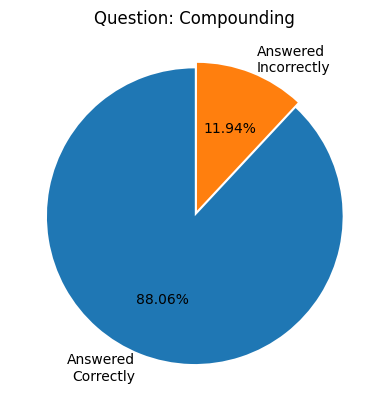

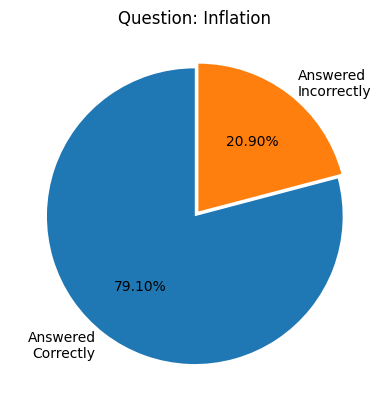

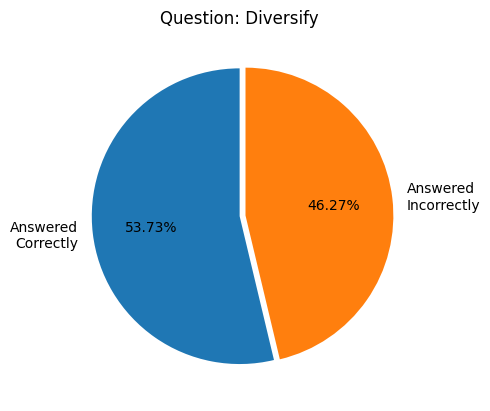

In [19]:
big_3 = pd.concat([t_df.iloc[:,0],t_df.iloc[:,45:48]],axis=1)
for i in big_3.drop('Fin_Lit',axis=1).columns:
    plt.pie(
        big_3.value_counts(i),
        labels=['Answered\nCorrectly','Answered\nIncorrectly'],
        autopct='%.2f%%',
        explode=[0,0.04],
        startangle=90
    )
    plt.title('Question: '+i)
    plt.show()

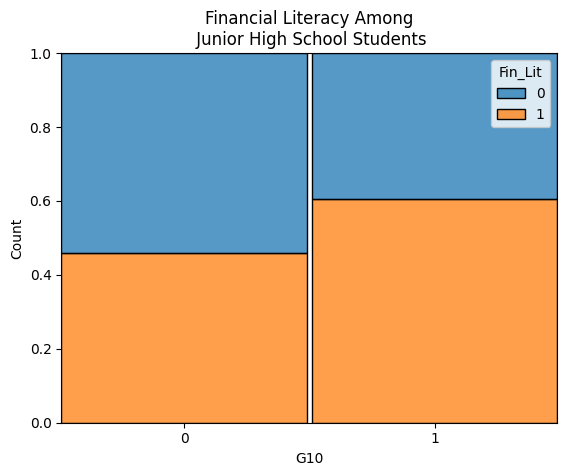

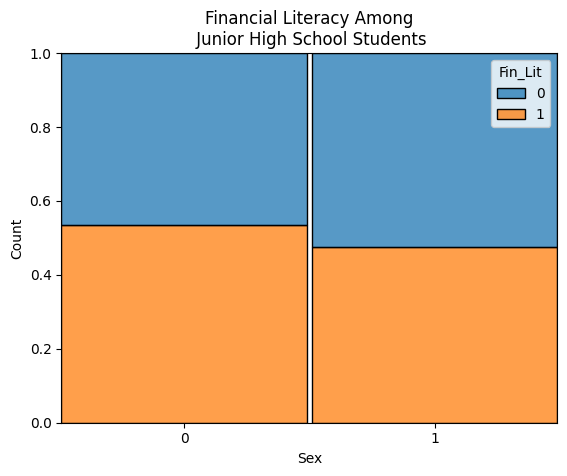

In [20]:
for i in t_df.iloc[:,0:3].drop('Fin_Lit',axis=1).columns:
    sns.histplot(
        data=t_df.iloc[:,0:3],
        x=t_df[i].astype('category'),
        hue='Fin_Lit',
        multiple='fill',
        shrink=0.98
    )
    plt.xticks([0,1])
    plt.title('Financial Literacy Among\n Junior High School Students')
    plt.show()

Text(0.5, 1.0, 'Financial Literacy According to\nTopics Learned')

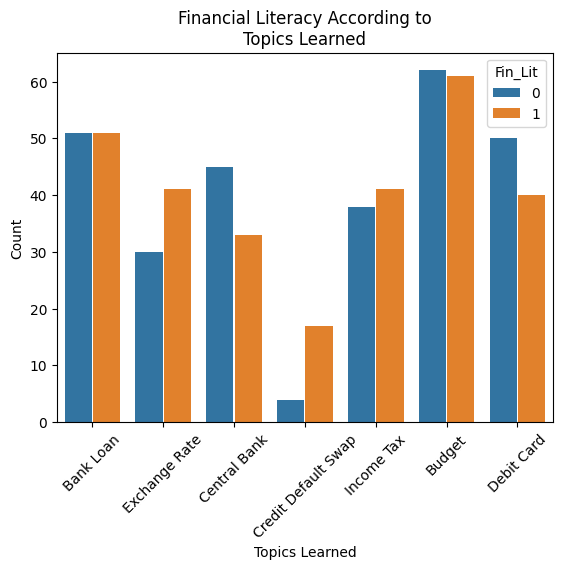

In [21]:
learn = t_df[list(t_list)].loc[:,t_df[list(t_list)].columns.str.contains('Learn')]
learn = pd.melt(
    pd.concat([t_df['Fin_Lit'],learn],axis=1).groupby('Fin_Lit').sum().reset_index(),
    id_vars='Fin_Lit',
)
sns.barplot(
    data=learn,
    x=learn['variable'].str.replace('Learn[“','').str.replace('”]','').str.title(),
    y='value',
    hue='Fin_Lit',
    gap=0.04
)
plt.xticks(rotation=45)
plt.xlabel('Topics Learned')
plt.ylabel('Count')
plt.title('Financial Literacy According to\nTopics Learned')

Text(0.5, 1.0, 'Financial Literacy According to\n Source of Information')

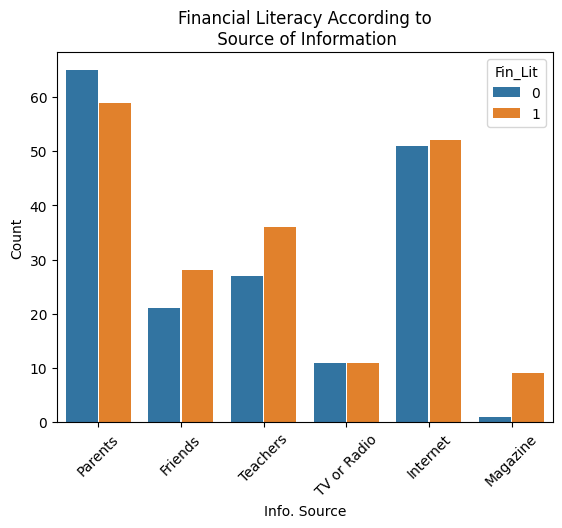

In [22]:
get_info = pd.concat([t_df.iloc[:,0],t_df.iloc[:,48:54]],axis=1).groupby('Fin_Lit').sum()
get_info.columns = ['Parents','Friends','Teachers','TV or Radio','Internet','Magazine']
get_info = pd.melt(get_info.reset_index(),id_vars=['Fin_Lit'])
sns.barplot(
    data=get_info,
    x='variable',
    y='value',
    hue='Fin_Lit',
    gap=0.04
)
plt.xticks(rotation=45)
plt.xlabel('Info. Source')
plt.ylabel('Count')
plt.title('Financial Literacy According to\n Source of Information')

Text(0.5, 1.0, 'Financial Literacy According to\n Topics Discussed')

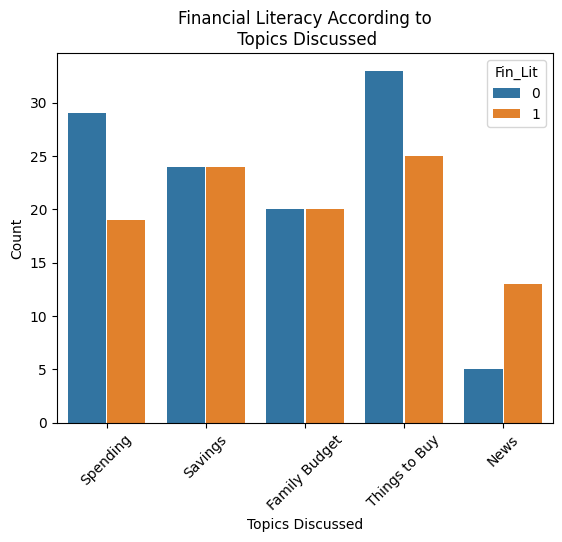

In [23]:
dis = pd.concat([t_df.iloc[:,0],t_df.iloc[:,32:37]],axis=1).groupby('Fin_Lit').sum()
dis.columns = ['Spending','Savings','Family Budget','Things to Buy','News']
dis = pd.melt(dis.reset_index(),id_vars='Fin_Lit')
sns.barplot(
    data=dis,
    x='variable',
    y='value',
    hue='Fin_Lit',
    gap=0.04
)
plt.xticks(rotation=45)
plt.xlabel('Topics Discussed')
plt.ylabel('Count')
plt.title('Financial Literacy According to\n Topics Discussed')

Text(0.5, 1.0, 'Financial Literacy According to\n Source of Income')

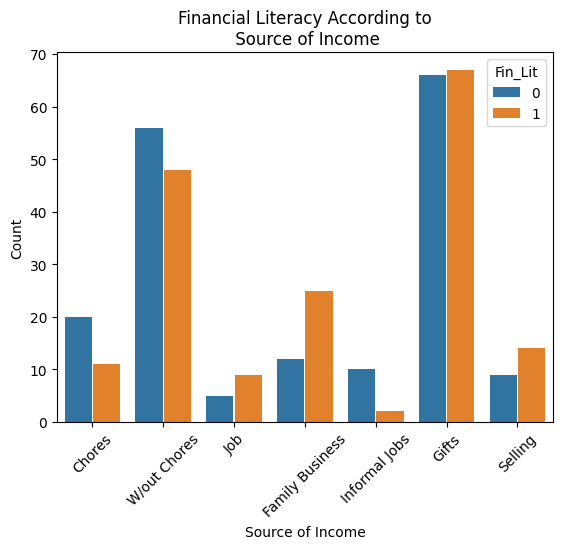

In [24]:
m_from = pd.concat([t_df.iloc[:,0],t_df.iloc[:,37:44]],axis=1).groupby('Fin_Lit').sum()
m_from.columns = ['Chores','W/out Chores', 'Job', 'Family Business', 'Informal Jobs', 'Gifts', 'Selling']
m_from = pd.melt(m_from.reset_index(),id_vars='Fin_Lit')
sns.barplot(
    data=m_from,
    x='variable',
    y='value',
    hue='Fin_Lit',
    gap=0.04
)
plt.xticks(rotation=45)
plt.xlabel('Source of Income')
plt.ylabel('Count')
plt.title('Financial Literacy According to\n Source of Income')

### Binary Logistic Regression
For the Binary Logistic Regression, I have further reduced the number of variables to 15. This is to avoid overfitting the model to __this__ particular sample and artificially boost the model's predictive capability. I have also chosen the variables whose relationships I personally want to measure the most (socio-demographics, learning opportunities, and source of information). 

After deciding on which variables to include in the model, I split the data into two: training and testing. As the names suggest, training data will be used for model estimation while testing data will be used for model validation (or how well does the model _actually_ predict outcomes). Splitting data is done to avoid overfitting the model to a particular sample, making it perform really well with sample data while underperforming to data that it has not seen/first time seeing.

The following interpretations should be read with an initial "_holding all other things constant_...," statement. For example:
>__`G10` -__ "positive(+). __Holding all other things constant__, Grade 10 Students are 48% more likely to be financially literate."

Significant Variables at __5% Significance Level__:
1. __`G10` -__ positive(+). Grade 10 Students are 48% more likely to be financially literate.

2. __`Never_Learn` -__ negative(-). Students who have never learned to manage their money in any setting whatsoever are 48% less likely to be financially literate.

3. __`Learn_CDS` -__ positive(+). Students who have learned of Credit Default Swap are more 58% likely to be financially literate.

4. __`Discuss_Spend` -__ negative(-). Students who often dicuss their spending decisions with their parents, guardians, and/or relatives are 50% less likely to be financially literate.

5. __`Parents` -__ negative(-). Students who get their financial information from their parents are 95% less likely to be financially literate.

6. __`Friends` -__ negative(-). Students who get their financial information from their friends are 30% less likely to be financially literate.

7. __`Internet` -__ negative(-). Students who get their financial information from the internet are 26% less likely to be financially literate.

8. __`TV_or_Radio` -__ negative(-). Students who get their financial information from the TV or Radio are 29% less likely to be financially literate.

9. __`Magazine` -__ positive(+). Students who get their financial information from Magazines are 63% more likely to be financially literate.

Significant Variables at __10% Significance Level__:
1. __`Discuss_Budget` -__ negative(-). Students who often discuss the family budget with their parents, guardians, and/or relatives are 26% less likely to be financially literate.

2. __`Teachers` -__ positive(+). Students who get their financial information from their teachers are 18% more likely to be financially literate.

3. __`M_From_Work` -__ positive(+). Students who get their money from engaging in selling, and/or family business are 16% more likely to be financially literate

On assessing the predictive performance of the model, it scored between 0.72 to 1.00(!). Accuracy, which measures the proportion of true positives and true negatives over total predictions, scored 0.80. In other words, 80% of the predictions were accurately binned by the model. Precision scored the lowest at 0.72, while Recall scored the highest at 1.00. This means that the model is _really_ good at identifying true negatives but somewhat struggles with false positives. It leans more towards classifying individuals as financially literate even when in reality, they are not. 

This could prove harmful since it is much costlier to classify a financially illiterate individual as financially literate than latter of classifying a financially literate individual as financially illiterate. In the former, no actions/interventions were implemented because we believed that they were financially capable individuals while the latter, even though the actions/interventions may not have been warranted, it was still supplied because we believed them to be financially illiterate. 

In other words, it truly is a tradeoff on which costs less: false positives or false negatives (and this is precisely the eternal debate of precision vs. recall). In this case, I would argue that false positives are actually costlier than false negatives. It is better to educate an already learned individual than to let an ignorant person go about their day thinking they are educated.

Still, when all is said and done, the model scored an F1 Score of 0.84, which is _quite good_. The model is balanced and does not rely heavily on either precision or recall.

In [26]:
var_list = [
    'Fin_Lit',
    'G10', 'Sex', 'L_M[I have never learned how to manage money in a course]',
    'Learn[“Credit default swap”]',
    'M_From_Work',
    'Discuss[News related to economics or finance]','Discuss_Spend', 'Discuss[Your savings decisions]','Discuss[The family budget]',
    'Parents/guardians or other adult relations', 'Teachers', 'Friends', 'The Internet', 'Television or radio', 'Magazines'
]
mod_df = t_df[var_list]
mod_col = [
    'Fin_Lit', 
    'G10', 'Sex','Never_Learn',
    'Learn_CDS', 
    'M_From_Work',
    'Discuss_News','Discuss_Spend','Discuss_Savings','Discuss_Budget',
    'Parents', 'Teachers', 'Friends', 'Internet', 'TV_or_Radio', 'Magazines'
]
mod_df.columns = mod_col
mod_df.head()

,Fin_Lit,G10,Sex,Never_Learn,Learn_CDS,M_From_Work,Discuss_News,Discuss_Spend,Discuss_Savings,Discuss_Budget,Parents,Teachers,Friends,Internet,TV_or_Radio,Magazines
0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0
1,1,1,1,0,0,1,0,1,1,1,1,1,0,1,0,0
2,0,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0
3,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,0
4,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0


In [27]:
x = mod_df.drop('Fin_Lit',axis=1)
y = mod_df['Fin_Lit']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=mod_df['Parents'])

t_data = pd.concat([y_train,x_train],axis=1)

In [28]:
x=""
for i in x_train.columns:
    x=x+" + "+i
formula = 'Fin_Lit ~ '+x[3:]

logit = smf.logit(formula = formula,data=t_data)
model = logit.fit()
model.summary(alpha=0.1)

Optimization terminated successfully.
         Current function value: 0.250196
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Fin_Lit   No. Observations:                   93
Model:                          Logit   Df Residuals:                       77
Method:                           MLE   Df Model:                           15
Date:                Fri, 24 Jan 2025   Pseudo R-squ.:                  0.6390
Time:                        19:21:05   Log-Likelihood:                -23.268
converged:                       True   LL-Null:                       -64.457
Covariance Type:            nonrobust   LLR p-value:                 2.559e-11
===================================================================================
                      coef    std err          z      P>|z|       [0.05       0.95]
-----------------------------------------------------------------------------------
Intercept          16.1524      5.272      3.064      0.002       7.481      24.824
G10                 5.9966      1.936      3.098      0.002       2.813       9.180
Sex                -0.4230      0.948     -0.446      0.656      -1.983       1.137
Never_Learn        -6.1083      1.951     -3.131      0.002      -9.317      -2.899
Learn_CDS           7.2475      2.731      2.654      0.008       2.756      11.739
M_From_Work         2.0109      1.112      1.808      0.071       0.181       3.841
Discuss_News        3.3356      2.268      1.471      0.141      -0.395       7.067
Discuss_Spend      -6.2675      2.348     -2.670      0.008     -10.129      -2.406
Discuss_Savings     1.8056      2.023      0.892      0.372      -1.523       5.134
Discuss_Budget     -3.2223      1.724     -1.869      0.062      -6.058      -0.387
Parents           -11.9024      3.919     -3.037      0.002     -18.348      -5.456
Teachers            2.2610      1.235      1.830      0.067       0.229       4.293
Friends            -3.7630      1.566     -2.404      0.016      -6.338      -1.188
Internet           -3.2596      1.461     -2.231      0.026      -5.663      -0.856
TV_or_Radio        -3.6943      1.668     -2.214      0.027      -6.439      -0.950
Magazines           7.9370      3.246      2.445      0.014       2.597      13.277
===================================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [29]:
model.get_margeff().summary(alpha=0.10)

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                Fin_Lit
Method:                          dydx
At:                           overall
===================================================================================
                     dy/dx    std err          z      P>|z|       [0.05       0.95]
-----------------------------------------------------------------------------------
G10                 0.4777      0.108      4.442      0.000       0.301       0.655
Sex                -0.0337      0.075     -0.447      0.655      -0.158       0.090
Never_Learn        -0.4866      0.112     -4.336      0.000      -0.671      -0.302
Learn_CDS           0.5774      0.174      3.316      0.001       0.291       0.864
M_From_Work         0.1602      0.080      1.993      0.046       0.028       0.292
Discuss_News        0.2657      0.168      1.585      0.113      -0.010       0.541
Discuss_Spend      -0.4993      0.150     -3.340      0.001      -0.745      -0.253
Discuss_Savings     0.1438      0.159      0.905      0.365      -0.118       0.405
Discuss_Budget     -0.2567      0.123     -2.093      0.036      -0.458      -0.055
Parents            -0.9483      0.230     -4.128      0.000      -1.326      -0.570
Teachers            0.1801      0.090      2.012      0.044       0.033       0.327
Friends            -0.2998      0.104     -2.885      0.004      -0.471      -0.129
Internet           -0.2597      0.103     -2.521      0.012      -0.429      -0.090
TV_or_Radio        -0.2943      0.116     -2.527      0.012      -0.486      -0.103
Magazines           0.6323      0.219      2.881      0.004       0.271       0.993
===================================================================================
"""

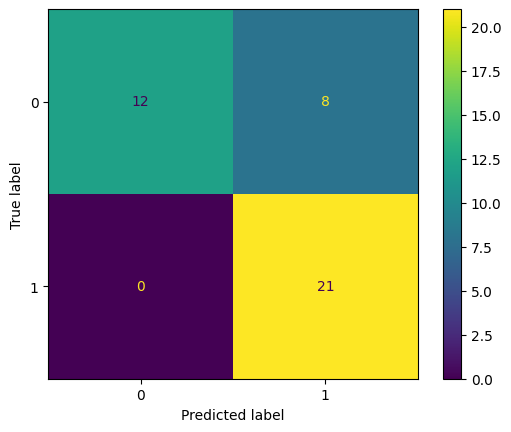

In [30]:
y_pred = round(model.predict(x_test))
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(cm).plot()

In [31]:
print('Accuracy: ', '%.2f' % metrics.accuracy_score(y_test,y_pred))
print('Precision: ', '%.2f' % metrics.precision_score(y_test,y_pred))
print('Recall: ', '%.2f' % metrics.recall_score(y_test,y_pred))
print('F1 Score: ', '%.2f' % metrics.f1_score(y_test,y_pred))

Accuracy:  0.80
Precision:  0.72
Recall:  1.00
F1 Score:  0.84


### Conclusion
If you've read this far, thank you! The main objective of this study really was just to identify which students were financially literate and illiterate. It was hoped that if we are able to identify patterns among those students who were financially illiterate then moving forward, perhaps the school can specifically create targeted policies/interventions for these students. And to some degree, we have accomplished that (and surprisingly, many more). So, to recap, here are just some of the most valuable insights generated within this study:
1. Most students struggled with the diversification question the most. It is clear then that should the school implement any action/intervention that the topic on diversification (and risk-reward) could be one of the primary objectives. Likewise, classes (i.e. economics, homeroom/guidance) can devote a brief lecture on risk (and how to mitigate it) in decision-making. It does not necessarily need to be highly technical; it only needs to be appropriate, grounded, and relatable for their age.

2. While at first glance, socio-demographics might have not been the most conclusive, it still indicated areas/sources of intervention. Firstly, while the difference might not be that significant between males and females, it still suggested that males were slightly more financially literate than females. In other words, if any actions/interventions were to be made, it would probably make sense to specifically target/cater it towards the females (but I personally think both sexes should be included in any action/intervention). Secondly (and this one's significant from the logistic regression), younger students are less likely to be financially literate than older students, which implies that should there be any actions/interventions to be made, it ought to target younger audiences than the older ones.  

3. Learning how to manage one's money should be discussed (at the very least, even once) in schools. Those who have never learned how to manage money in either settings (school, household, outside school, etc.) are less likely to be financially literate than those who had the opportunity to learn about it. Leaving it to fate/chance that the students would _eventually_ learn it anyway sounds irresponsible when it is clearly within our means to better the odds against financial illiteracy. And perhaps more importantly, it is better to fail at learning how to manage one's money in a safe, and controlled environment (like a school) rather than failing it _later_ in life.

4. The role of parents cannot be understated in the battle against financial illiteracy for they are the primary beacons of financial information for our students. And yet, most students were financially illiterate. So, what is going on? (1) It could be that most parents are financially illiterate themselves and are feeding the students misinformation. Or (2) there is grave miscommunication between parents and students; parents might be giving the correct information but due to the limited understanding of the student, twists/misinterprets the information received. Whichever the _true_ reason may be, one thing is clear and that is the school should involve parents as a vital stakeholder in whichever policy/intervention it seeks to implement.

5. Expanding further on the former point, parents ought to curate the financial topics that is being discussed within their households for not all topics are created equal. For example, students who have often discussed "spending" and "budgetting" decisions with their parents, guardians, and/or relatives are less likely to be financially literate than those who don't. Either these discussions (1) encourage students to be more precarious with their finances, thereby leading to their financial ruin or (2) students who like to discuss about "spending" are already problematic spenders in the first place. Whichever the reason may be, it leads to negative outcomes with regards to their financial literacy. Instead, parents can opt to discuss "savings" and "financial/economic news" with their kids as both have shown to positively influence financial literacy. It encourages children to think, rethink, their decisions and further learn about finance/money/economics.

6. Having students _work_ for their money could lead to them being more likely to be financially literate. That is not to say that kids their age ought to be working. Of course not! But rather that involving kids in the family business, or making them _slightly_ work for their money (e.g. through chores, doing well in class, etc.) could teach them valuable lessons about the _value_ of money. It is a well-studied phenomenon in economics that people _do_ value things that they own/worked for in comparison to things that they have received for free/without costs (i.e. tragedy of the commons, endowment effect). And the same principles are at work here; if we want students to be financially literate then they must first understand the weight, effort, and toll it takes to _actually_ create value/money.

7. Students who have listed "magazines" as one of their sources of financial information are more likely to be financially literate. This does not mean that "magazines" contain "best" information on finance but rather that students who actively look for materials/references outside of the usual suspects (parents, teachers, classroom, etc.) are more likely to succeed. In other words, a point of action/intervention could be to encourage this whole process of self-discovery more by enabling the _capabilities_ which allow such processes to happen in the first place. For example, if books related to finance/economics are easily accessible in the library then that increases the probability of students eventually stumbling, reading, and learning from those materials. The school does not necessarily need to buy magazines but instead, it should actively create opportunities for students to think, process, and learn about financial literacy.

To conclude, these recommendations may not be the most revolutionary nor these may not be the most effective BUT these are definitely concrete steps towards the path of financial literacy. While most questions of the study are answered satisfactorily (who are the financially literate?), more questions did come up during the analysis (how impactful is the role of parents (or income, household size, presence of family business, etc.) in determining a child's financial literacy?) which could prove to be interesting topics to research on themselves. Ultimately, given the data and of what we _know_ today, these are the _best_ decisions for tomorrow.